In [1]:
from readgssi import readgssi
from readgssi import plot
import matplotlib.pyplot as plt 
import numpy as np
import matplotlib.colors as colors

In [2]:
def find_plate(array):
    """Returns depth (z) and position (x) of aluminium plate"""
    z, x = np.where(array==array.max())
    return int(z), int(x)

def find_x_coordinate(x, position):
    """Returns index position given meters"""
    return int(np.where(x==position)[0])

def find_sleeper_and_space(array, x, position_low, position_high):
    """Returns index position of sleepers and inbetween sleepers given a range position"""
    z, _ = find_plate(array)
    x_low, x_high = find_x_coordinate(x, position_low), find_x_coordinate(x, position_high)
    x_sleeper = array[z, x_low:x_high].argmax() + x_low
    return x_sleeper, x_sleeper + 65
    
def prepare_data(file, ar=0, remove_mean=True, triangular_filter=False, epsilon=25):
    """Read and prepare DZT data"""
    path_c = f'.\Otelfingen_20_12_2021\{file}.DZT'
    header, arrs, gps = readgssi.readgssi(path_c, antfreq=[1000, None, None, None])
    if int(file[-1])%2==0:
        arrs[ar] = readgssi.arrayops.flip(arrs[ar]) #reversed
    array = arrs[ar][:,:].copy().astype("float")
    if remove_mean:
        array = array-np.mean(array,axis=1).reshape(-1,1)
    if triangular_filter:
        array = readgssi.filtering.triangular(array, header, 700, 1300, zerophase=True, verbose=False)
    x = np.arange(0, array.shape[1]/200+1/200 ,1/200)[:-1]
    y = np.arange(0, header['rhf_range']*(1+1/array.shape[0]),header['rhf_range']/array.shape[0])[:-1]
    y = y*0.3/(2*epsilon**0.5)
    return array, x, y

def plot_radargram(ax, x, y, array, lim_inf, lim_sup, title, vlines=False):
    groundreflectionlimit = np.argmax(array.mean(axis=1))
    step = 5
    ll = np.min(array[groundreflectionlimit+step:,:])
    ul = np.max(array[groundreflectionlimit+step:,:])
    std = np.std(array[groundreflectionlimit+step:,:])
    gain = 1
    ax.pcolormesh(x,y,array, cmap='viridis', clim=(ll, ul),
                     norm=colors.SymLogNorm(linthresh=float(std)/float(gain),vmin=ll, vmax=ul, base=np.e)
                 )
    ax.invert_yaxis()
    ax.set_xlim(lim_inf,lim_sup)
    ax.set_xlabel('Distance (m)')
    ax.set_ylabel('Depth (m)')
    ax.set_title(f'{title}')
    if vlines:
        x_sleeper, x_inbetween = vlines
        ax.vlines(x[x_sleeper], y.min(), y.max(), colors='r', linestyles='dashed')
        ax.vlines(x[x_inbetween], y.min(), y.max(), colors='r', linestyles='dashed');

def plot_amplitude_along_x(ax, x, y, array, z, lim_inf, lim_sup, vlines):
    ax.plot(x, array[z, :])
    ax.set_xlim(lim_inf,lim_sup)
    ax.set_xlabel('Distance (m)')
    ax.set_ylabel('Amplitude')
    ax.set_title(f'Amplitude at ground level along x-axis')
    if vlines:
        x_sleeper, x_inbetween = vlines
        ax.vlines(x[x_sleeper], array[z, :].min(), array[z, :].max(), colors='r', linestyles='dashed')
        ax.vlines(x[x_inbetween], array[z, :].min(), array[z, :].max(), colors='r', linestyles='dashed');
        
def plot_amplitude_along_z(ax, x, y, array, x_coordinate, title=None):
    ax.plot(y, array[:, x_coordinate])
    ax.set_xlabel('Depth (m)')
    ax.set_ylabel('Amplitude')
    if title:
        ax.set_title(title)
    else:
        ax.set_title(f'Amplitude at {x[x_coordinate]}m along z-axis');

2022-01-20 10:34:02 - WARNING: no time zero specified for channel 0, defaulting to rh_zero value (2)
2022-01-20 10:34:02 - WARNING: no DZG file found for GPS input
--------------------WARNING - PLEASE READ---------------------
2022-01-20 10:34:02 - WARNING: could not read frequency for antenna name "'41000SA'"
2022-01-20 10:34:02 - using user-specified antenna frequency. Please ensure frequency value or list of values is correct.
2022-01-20 10:34:02 - old values: [41000, None, None, None]
2022-01-20 10:34:02 - new values: [1000, None, None, None]
2022-01-20 10:34:02 - more info: rh_ant=['41000SA', None, None, None]
2022-01-20 10:34:02 -            known_ant=[False, None, None, None]
2022-01-20 10:34:02 - please submit a bug report with this warning, the antenna name and frequency
2022-01-20 10:34:02 - at https://github.com/iannesbitt/readgssi/issues/new
2022-01-20 10:34:02 - or send via email to ian (dot) nesbitt (at) gmail (dot) com.
2022-01-20 10:34:02 - if possible, please attach a 

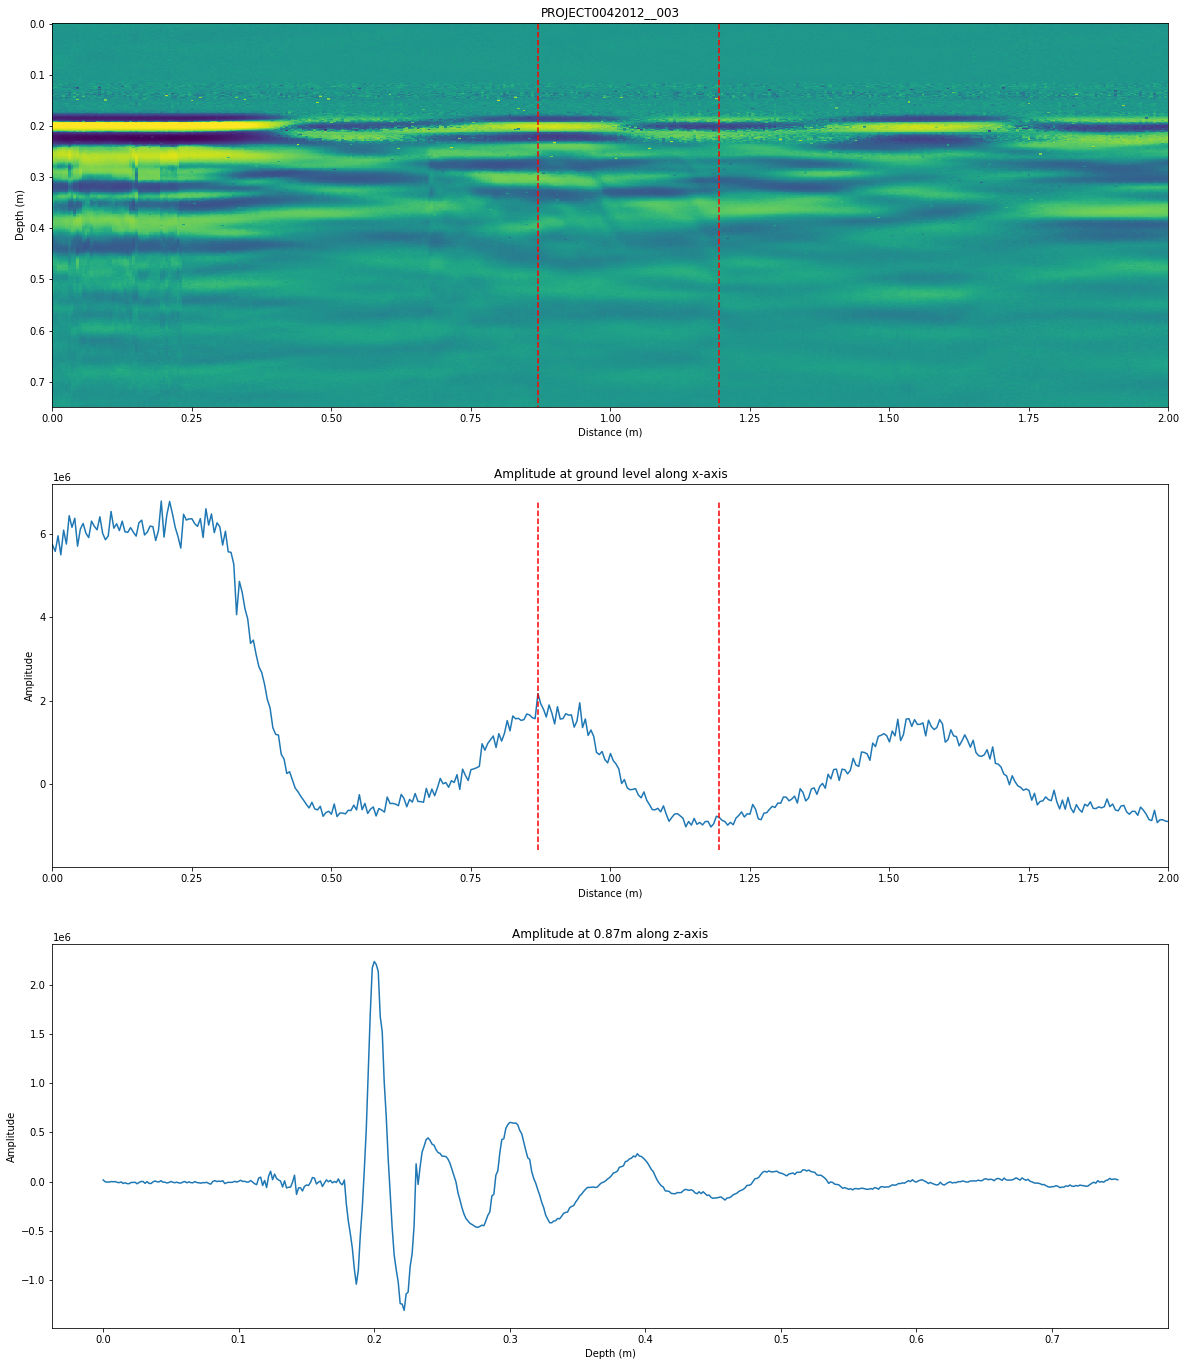

In [3]:
file_0 = 'PROJECT0042012__003' # 0 degree
file_45 = 'PROJECT0042012__007' # 45 degree
file_90 = 'PROJECT0042012__006' # 90 degree

array, x, y = prepare_data(file_0)
z_plate, x_plate = find_plate(array)
x_sleeper, x_inbetween = find_sleeper_and_space(array, x, position_low=0.5, position_high=1.5)

_, ax = plt.subplots(3,1,figsize=(20,24))
plot_radargram(ax[0], x, y, array, lim_inf=0, lim_sup=2, title=file_0, vlines=(x_sleeper, x_inbetween))
plot_amplitude_along_x(ax[1], x, y, array, z_plate, lim_inf=0, lim_sup=2, vlines=(x_sleeper, x_inbetween))
plot_amplitude_along_z(ax[2], x, y, array, x_sleeper)

In [4]:
file_0 = 'PROJECT0042012__003' # 0 degree
file_45 = 'PROJECT0042012__007' # 45 degree
file_90 = 'PROJECT0042012__006' # 90 degree

array_0, x_0, y_0 = prepare_data(file_0)
z_plate_0, x_plate_0 = find_plate(array_0)

array_45, x_45, y_45 = prepare_data(file_45)
z_plate_45, x_plate_45 = find_plate(array_45)

array_90, x_90, y_90 = prepare_data(file_90)
z_plate_90, x_plate_90 = find_plate(array_90)

2022-01-20 10:34:16 - WARNING: no time zero specified for channel 0, defaulting to rh_zero value (2)
2022-01-20 10:34:16 - WARNING: no DZG file found for GPS input
--------------------WARNING - PLEASE READ---------------------
2022-01-20 10:34:16 - WARNING: could not read frequency for antenna name "'41000SA'"
2022-01-20 10:34:16 - using user-specified antenna frequency. Please ensure frequency value or list of values is correct.
2022-01-20 10:34:16 - old values: [41000, None, None, None]
2022-01-20 10:34:16 - new values: [1000, None, None, None]
2022-01-20 10:34:16 - more info: rh_ant=['41000SA', None, None, None]
2022-01-20 10:34:16 -            known_ant=[False, None, None, None]
2022-01-20 10:34:16 - please submit a bug report with this warning, the antenna name and frequency
2022-01-20 10:34:16 - at https://github.com/iannesbitt/readgssi/issues/new
2022-01-20 10:34:16 - or send via email to ian (dot) nesbitt (at) gmail (dot) com.
2022-01-20 10:34:16 - if possible, please attach a 

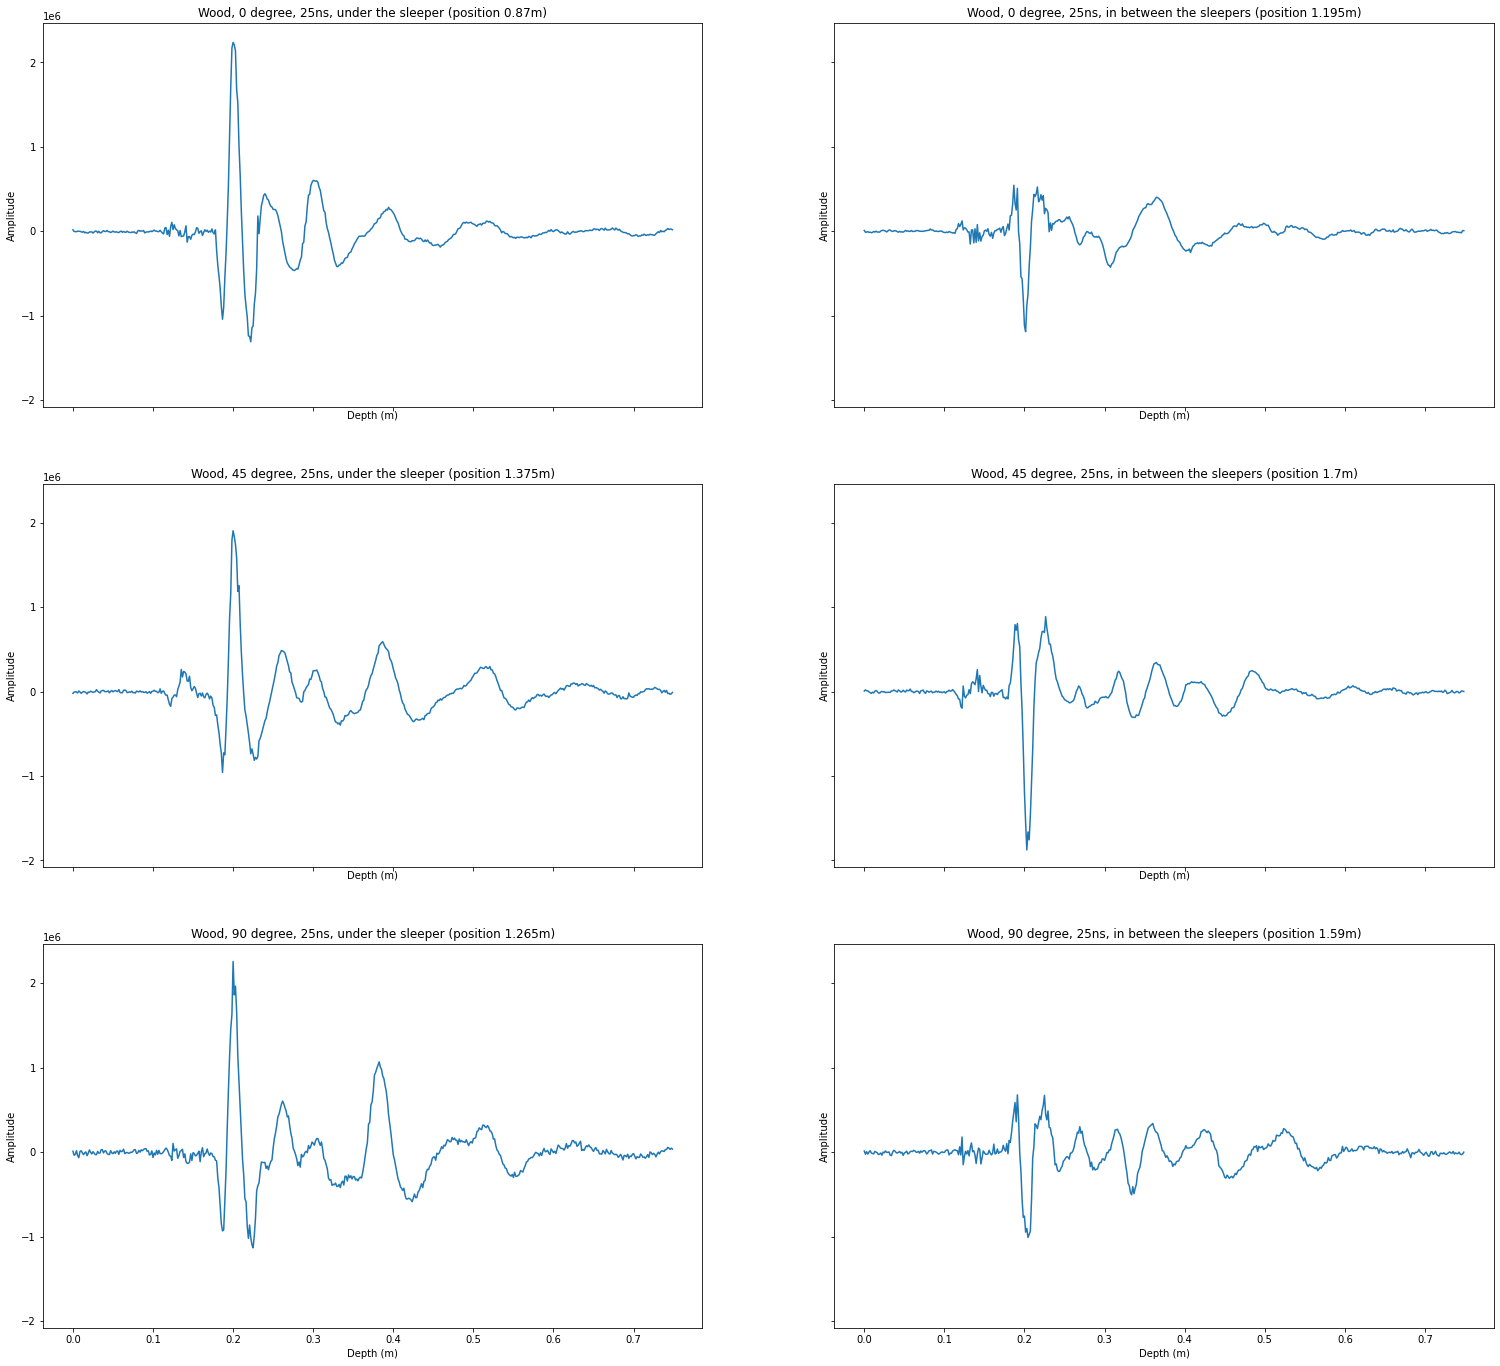

In [5]:
### Wood

_, ax = plt.subplots(3,2,figsize=(26,24),sharex=True, sharey=True)

### 0 degree
x_sleeper_0, x_inbetween_0 = find_sleeper_and_space(array_0, x_0, position_low=0.5, position_high=1.5)
plot_amplitude_along_z(ax[0][0], x_0, y_0, array_0, x_sleeper_0, 
                           title=f'Wood, 0 degree, 25ns, under the sleeper (position {x_0[x_sleeper_0].round(3)}m)')
plot_amplitude_along_z(ax[0][1], x_0, y_0, array_0, x_inbetween_0, 
                           title=f'Wood, 0 degree, 25ns, in between the sleepers (position {x_0[x_inbetween_0].round(3)}m)')
### 45 degree
x_sleeper_45, x_inbetween_45 = find_sleeper_and_space(array_45, x_45, position_low=0.5, position_high=1.5)
plot_amplitude_along_z(ax[1][0], x_45, y_45, array_45, x_sleeper_45, 
                           title=f'Wood, 45 degree, 25ns, under the sleeper (position {x_45[x_sleeper_45].round(3)}m)')
plot_amplitude_along_z(ax[1][1], x_45, y_45, array_45, x_inbetween_45, 
                           title=f'Wood, 45 degree, 25ns, in between the sleepers (position {x_45[x_inbetween_45].round(3)}m)')
### 90 degree
x_sleeper_90, x_inbetween_90 = find_sleeper_and_space(array_90, x_90, position_low=0.5, position_high=1.5)
plot_amplitude_along_z(ax[2][0], x_90, y_90, array_90, x_sleeper_90, 
                           title=f'Wood, 90 degree, 25ns, under the sleeper (position {x_90[x_sleeper_90].round(3)}m)')
plot_amplitude_along_z(ax[2][1], x_90, y_90, array_90, x_inbetween_90, 
                           title=f'Wood, 90 degree, 25ns, in between the sleepers (position {x_90[x_inbetween_90].round(3)}m)')

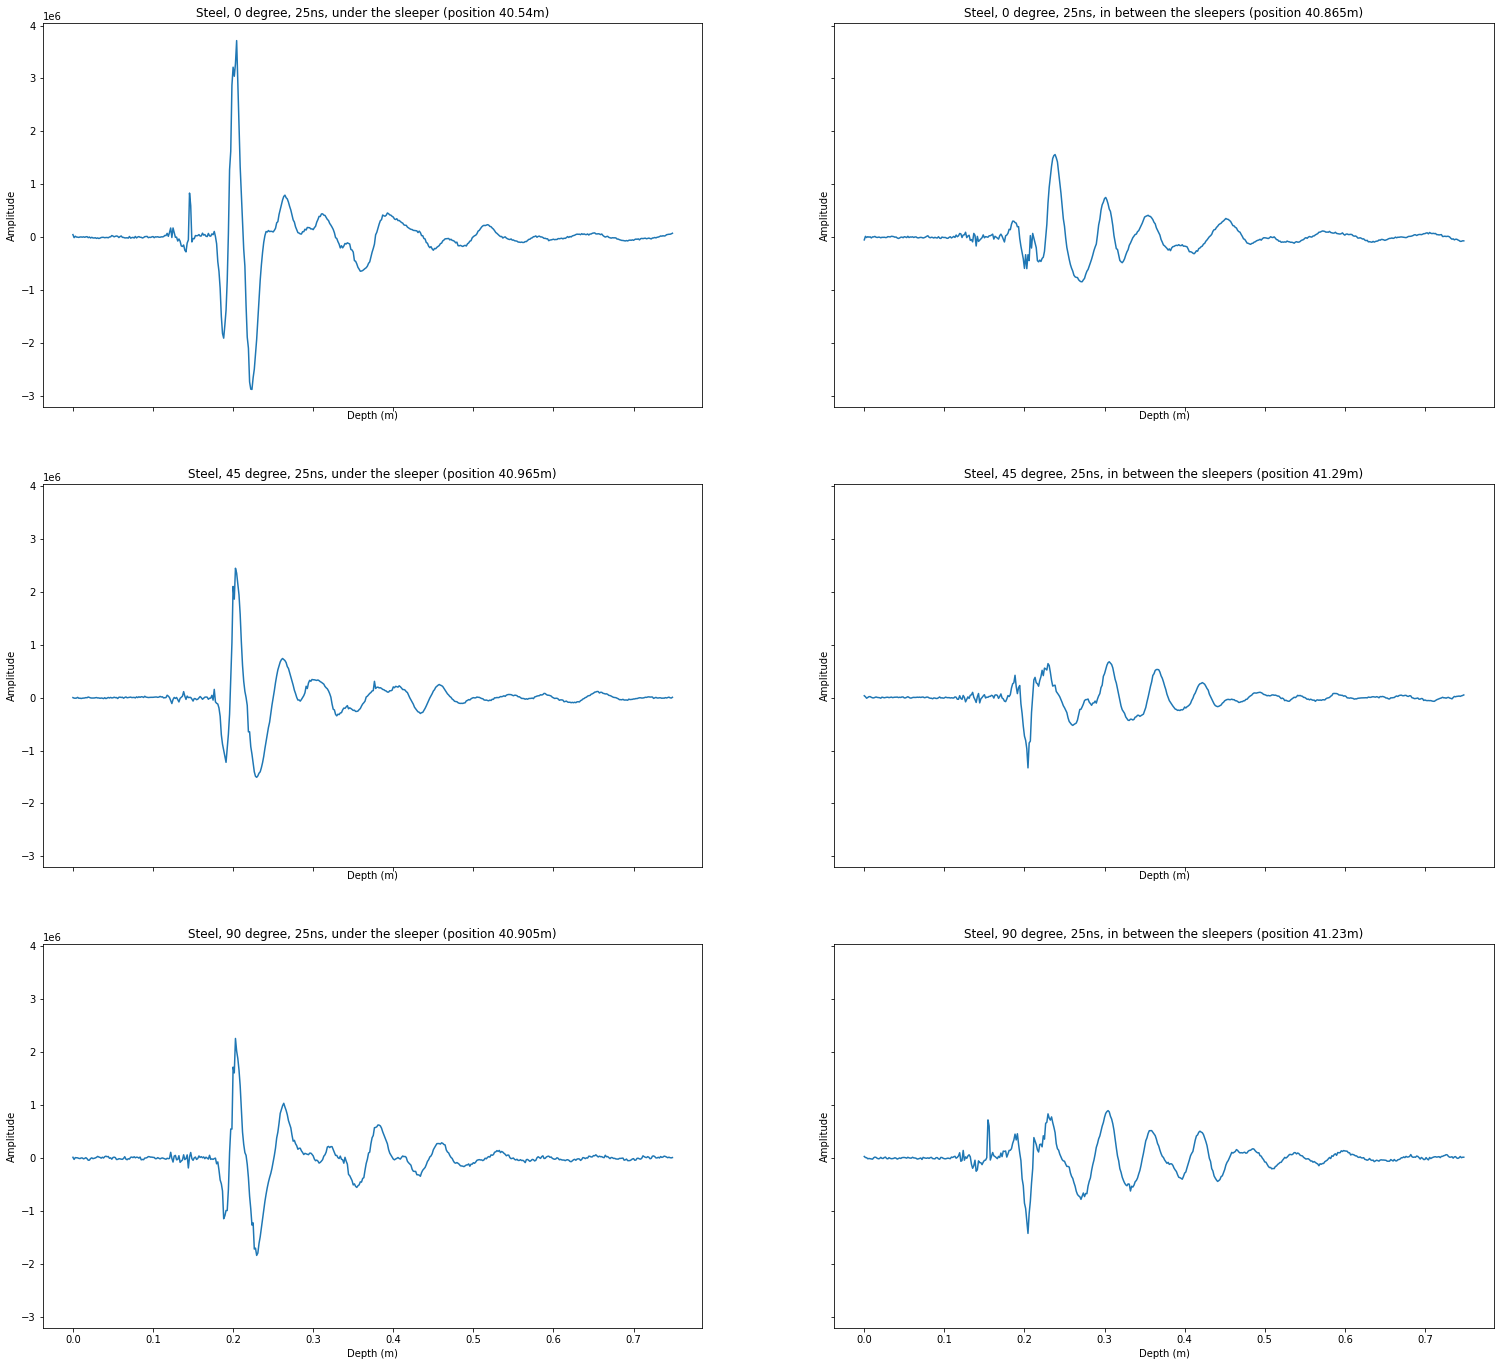

In [6]:
### Steel

_, ax = plt.subplots(3,2,figsize=(26,24),sharex=True, sharey=True)

### 0 degree
x_sleeper_0, x_inbetween_0 = find_sleeper_and_space(array_0, x_0, position_low=40.5, position_high=41.5)
plot_amplitude_along_z(ax[0][0], x_0, y_0, array_0, x_sleeper_0, 
                           title=f'Steel, 0 degree, 25ns, under the sleeper (position {x_0[x_sleeper_0].round(3)}m)')
plot_amplitude_along_z(ax[0][1], x_0, y_0, array_0, x_inbetween_0, 
                           title=f'Steel, 0 degree, 25ns, in between the sleepers (position {x_0[x_inbetween_0].round(3)}m)')
### 45 degree
x_sleeper_45, x_inbetween_45 = find_sleeper_and_space(array_45, x_45, position_low=40.5, position_high=41.5)
plot_amplitude_along_z(ax[1][0], x_45, y_45, array_45, x_sleeper_45, 
                           title=f'Steel, 45 degree, 25ns, under the sleeper (position {x_45[x_sleeper_45].round(3)}m)')
plot_amplitude_along_z(ax[1][1], x_45, y_45, array_45, x_inbetween_45, 
                           title=f'Steel, 45 degree, 25ns, in between the sleepers (position {x_45[x_inbetween_45].round(3)}m)')
### 90 degree
x_sleeper_90, x_inbetween_90 = find_sleeper_and_space(array_90, x_90, position_low=40.5, position_high=41.5)
plot_amplitude_along_z(ax[2][0], x_90, y_90, array_90, x_sleeper_90, 
                           title=f'Steel, 90 degree, 25ns, under the sleeper (position {x_90[x_sleeper_90].round(3)}m)')
plot_amplitude_along_z(ax[2][1], x_90, y_90, array_90, x_inbetween_90, 
                           title=f'Steel, 90 degree, 25ns, in between the sleepers (position {x_90[x_inbetween_90].round(3)}m)')

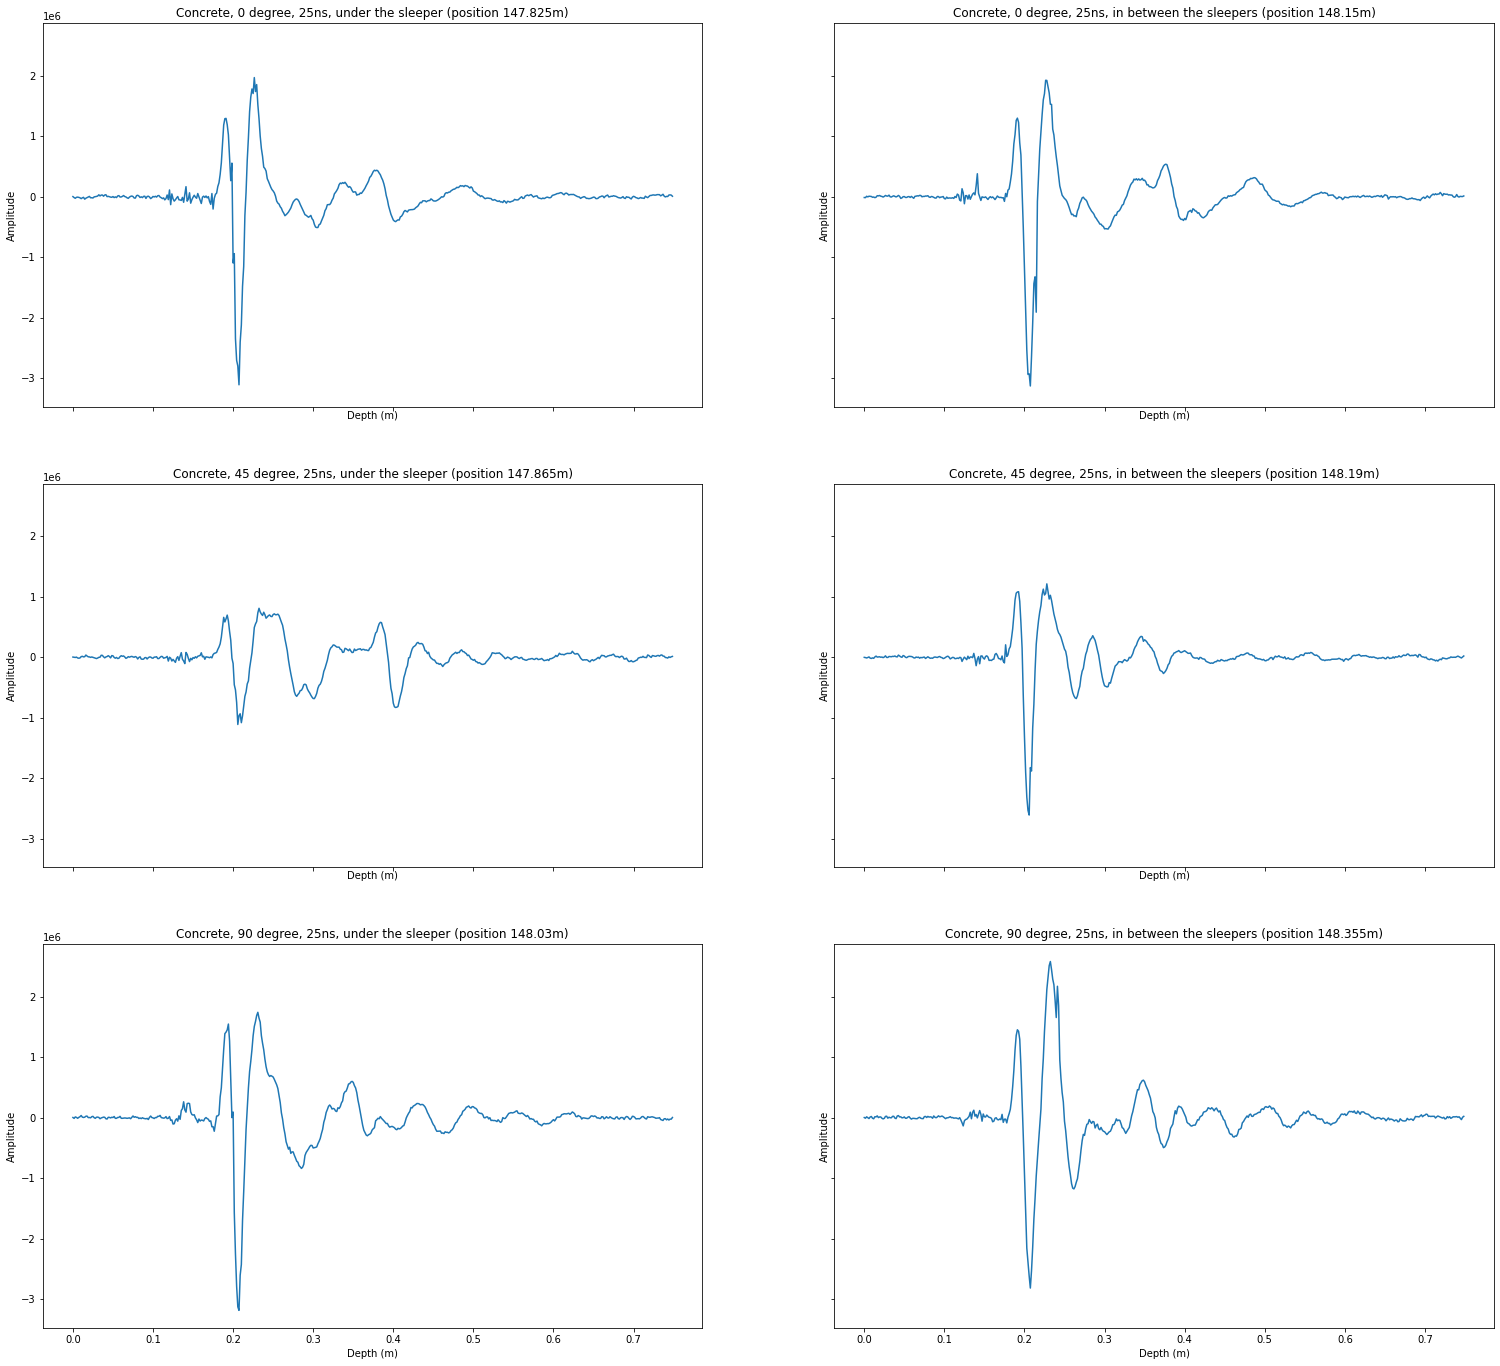

In [7]:
### Concrete

_, ax = plt.subplots(3,2,figsize=(26,24),sharex=True, sharey=True)

### 0 degree
x_sleeper_0, x_inbetween_0 = find_sleeper_and_space(array_0, x_0, position_low=147.5, position_high=148.5)
plot_amplitude_along_z(ax[0][0], x_0, y_0, array_0, x_sleeper_0, 
                           title=f'Concrete, 0 degree, 25ns, under the sleeper (position {x_0[x_sleeper_0].round(3)}m)')
plot_amplitude_along_z(ax[0][1], x_0, y_0, array_0, x_inbetween_0, 
                           title=f'Concrete, 0 degree, 25ns, in between the sleepers (position {x_0[x_inbetween_0].round(3)}m)')
### 45 degree
x_sleeper_45, x_inbetween_45 = find_sleeper_and_space(array_45, x_45, position_low=147.5, position_high=148.5)
plot_amplitude_along_z(ax[1][0], x_45, y_45, array_45, x_sleeper_45, 
                           title=f'Concrete, 45 degree, 25ns, under the sleeper (position {x_45[x_sleeper_45].round(3)}m)')
plot_amplitude_along_z(ax[1][1], x_45, y_45, array_45, x_inbetween_45, 
                           title=f'Concrete, 45 degree, 25ns, in between the sleepers (position {x_45[x_inbetween_45].round(3)}m)')
### 90 degree
x_sleeper_90, x_inbetween_90 = find_sleeper_and_space(array_90, x_90, position_low=147.5, position_high=148.5)
plot_amplitude_along_z(ax[2][0], x_90, y_90, array_90, x_sleeper_90, 
                           title=f'Concrete, 90 degree, 25ns, under the sleeper (position {x_90[x_sleeper_90].round(3)}m)')
plot_amplitude_along_z(ax[2][1], x_90, y_90, array_90, x_inbetween_90, 
                           title=f'Concrete, 90 degree, 25ns, in between the sleepers (position {x_90[x_inbetween_90].round(3)}m)')

## Adding GPR radargram

In [8]:
def set_share_axes(axs, target=None, sharex=False, sharey=False):
    if target is None:
        target = axs.flat[0]
    # Manage share using grouper objects
    for ax in axs.flat:
        if sharex:
            target._shared_axes['x'].join(target, ax)
        if sharey:
            target._shared_axes['y'].join(target, ax)
    # Turn off x tick labels and offset text for all but the bottom row
    if sharex and axs.ndim > 1:
        for ax in axs[:-1,:].flat:
            ax.xaxis.set_tick_params(which='both', labelbottom=False, labeltop=False)
            ax.xaxis.offsetText.set_visible(False)
    # Turn off y tick labels and offset text for all but the left most column
    if sharey and axs.ndim > 1:
        for ax in axs[:,1:].flat:
            ax.yaxis.set_tick_params(which='both', labelleft=False, labelright=False)
            ax.yaxis.offsetText.set_visible(False)

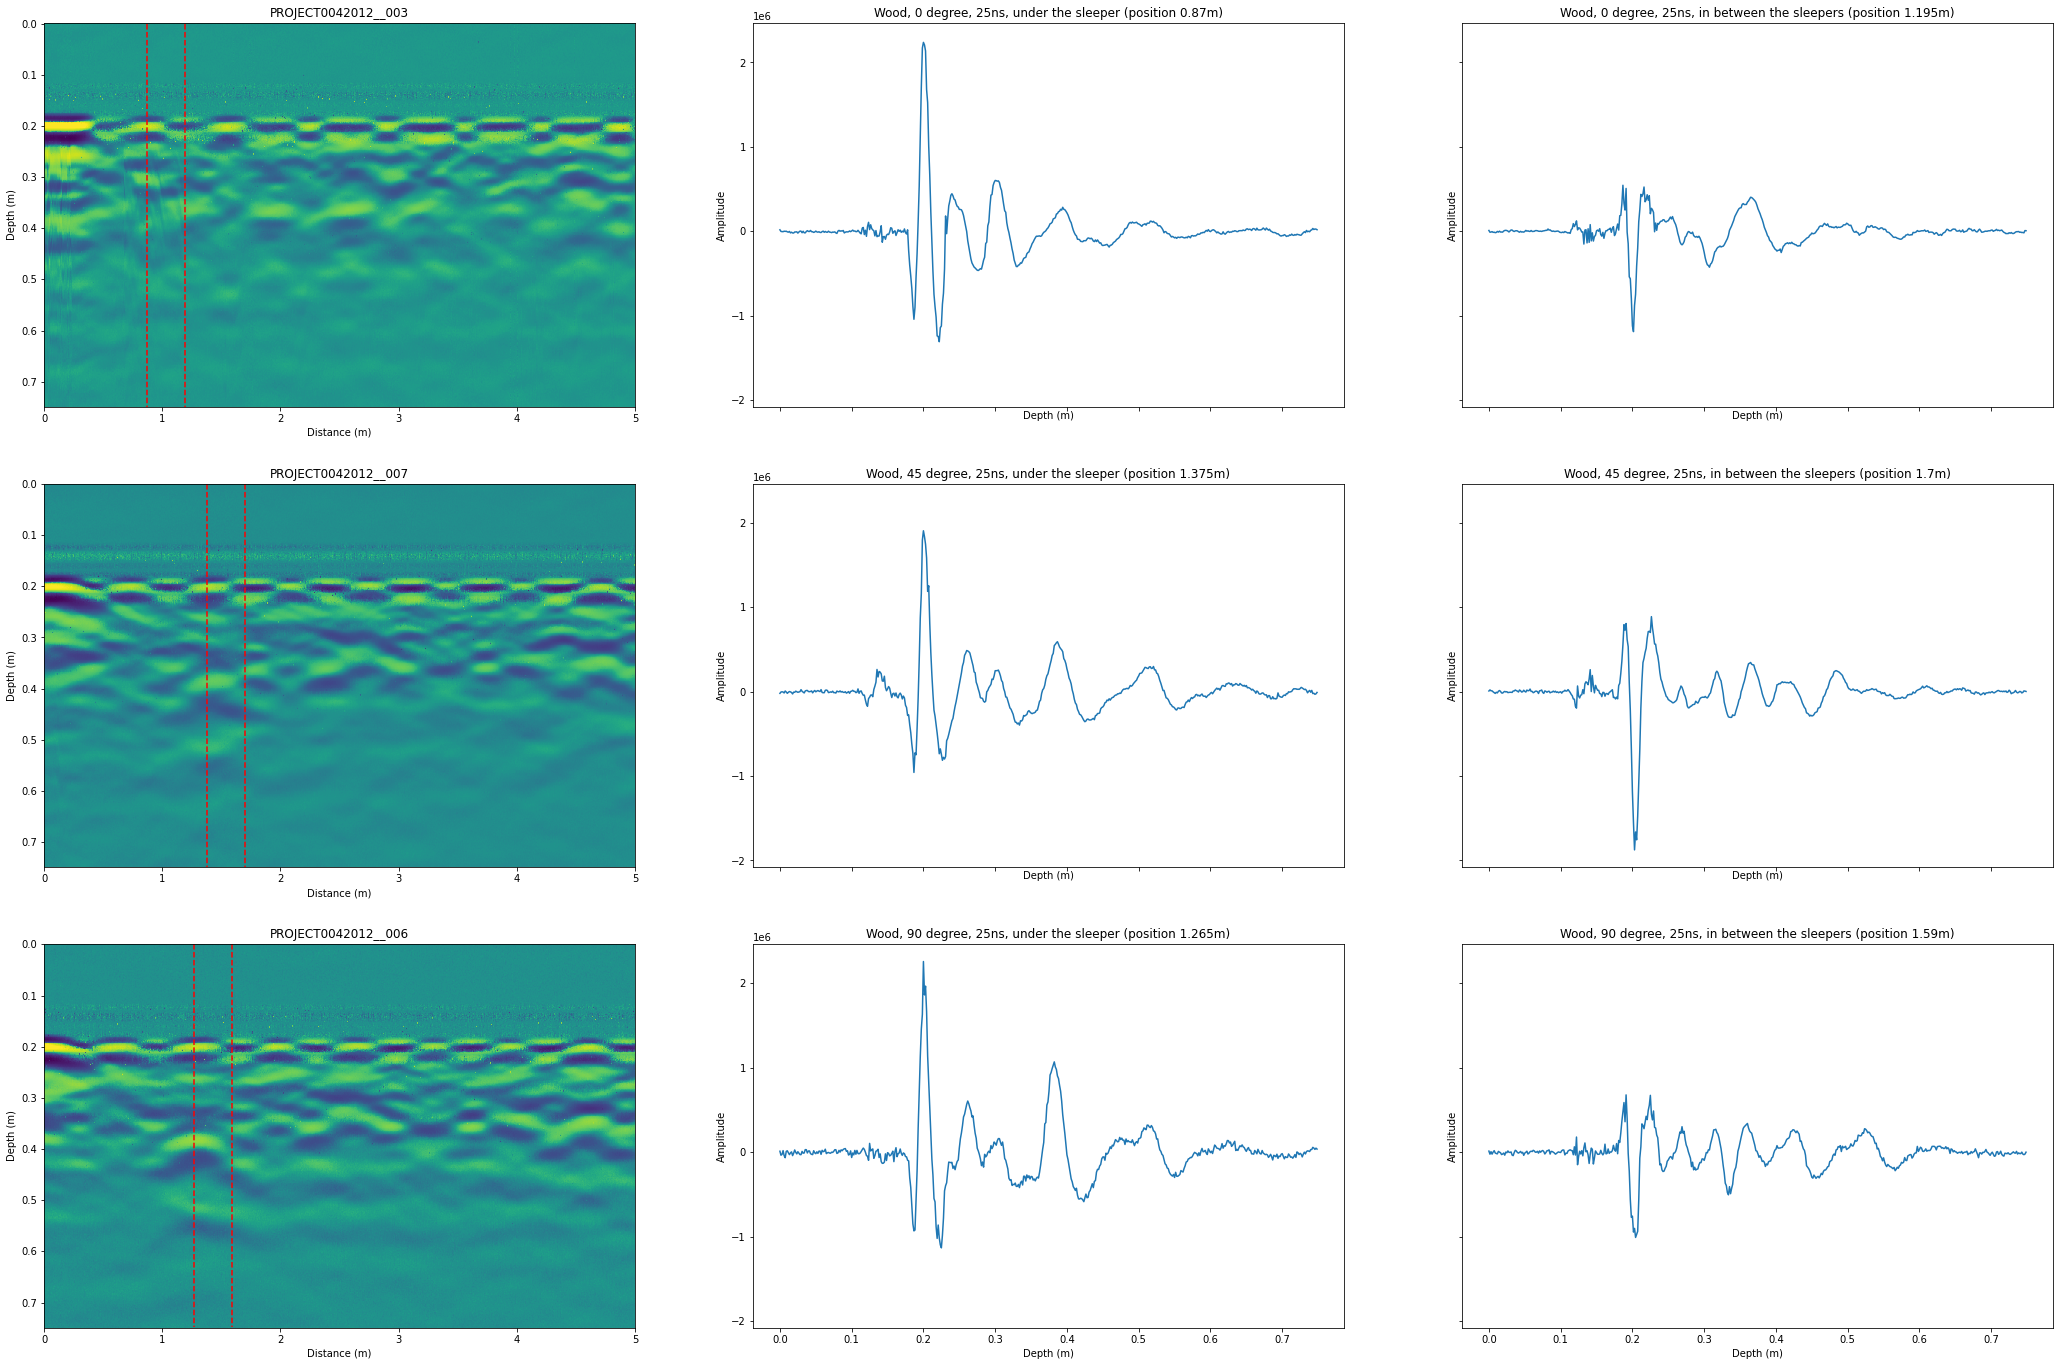

In [9]:
### Wood

_, ax = plt.subplots(3,3,figsize=(36,24))
set_share_axes(ax[:,0], sharex=True, sharey=True)
set_share_axes(ax[:,1:], sharex=True, sharey=True)

### 0 degree
x_sleeper_0, x_inbetween_0 = find_sleeper_and_space(array_0, x_0, position_low=0.5, position_high=1.5)
plot_radargram(ax[0][0], x_0, y_0, array_0, lim_inf=0, lim_sup=5, title=file_0, vlines=(x_sleeper_0, x_inbetween_0))
plot_amplitude_along_z(ax[0][1], x_0, y_0, array_0, x_sleeper_0, 
                           title=f'Wood, 0 degree, 25ns, under the sleeper (position {x_0[x_sleeper_0].round(3)}m)')
plot_amplitude_along_z(ax[0][2], x_0, y_0, array_0, x_inbetween_0, 
                           title=f'Wood, 0 degree, 25ns, in between the sleepers (position {x_0[x_inbetween_0].round(3)}m)')
### 45 degree
x_sleeper_45, x_inbetween_45 = find_sleeper_and_space(array_45, x_45, position_low=0.5, position_high=1.5)
plot_radargram(ax[1][0], x_45, y_45, array_45, lim_inf=0, lim_sup=5, title=file_45, vlines=(x_sleeper_45, x_inbetween_45))
plot_amplitude_along_z(ax[1][1], x_45, y_45, array_45, x_sleeper_45, 
                           title=f'Wood, 45 degree, 25ns, under the sleeper (position {x_45[x_sleeper_45].round(3)}m)')
plot_amplitude_along_z(ax[1][2], x_45, y_45, array_45, x_inbetween_45, 
                           title=f'Wood, 45 degree, 25ns, in between the sleepers (position {x_45[x_inbetween_45].round(3)}m)')
### 90 degree
x_sleeper_90, x_inbetween_90 = find_sleeper_and_space(array_90, x_90, position_low=0.5, position_high=1.5)
plot_radargram(ax[2][0], x_90, y_90, array_90, lim_inf=0, lim_sup=5, title=file_90, vlines=(x_sleeper_90, x_inbetween_90))
plot_amplitude_along_z(ax[2][1], x_90, y_90, array_90, x_sleeper_90, 
                           title=f'Wood, 90 degree, 25ns, under the sleeper (position {x_90[x_sleeper_90].round(3)}m)')
plot_amplitude_along_z(ax[2][2], x_90, y_90, array_90, x_inbetween_90, 
                           title=f'Wood, 90 degree, 25ns, in between the sleepers (position {x_90[x_inbetween_90].round(3)}m)')
#plt.savefig('comparison_9x9_wood')

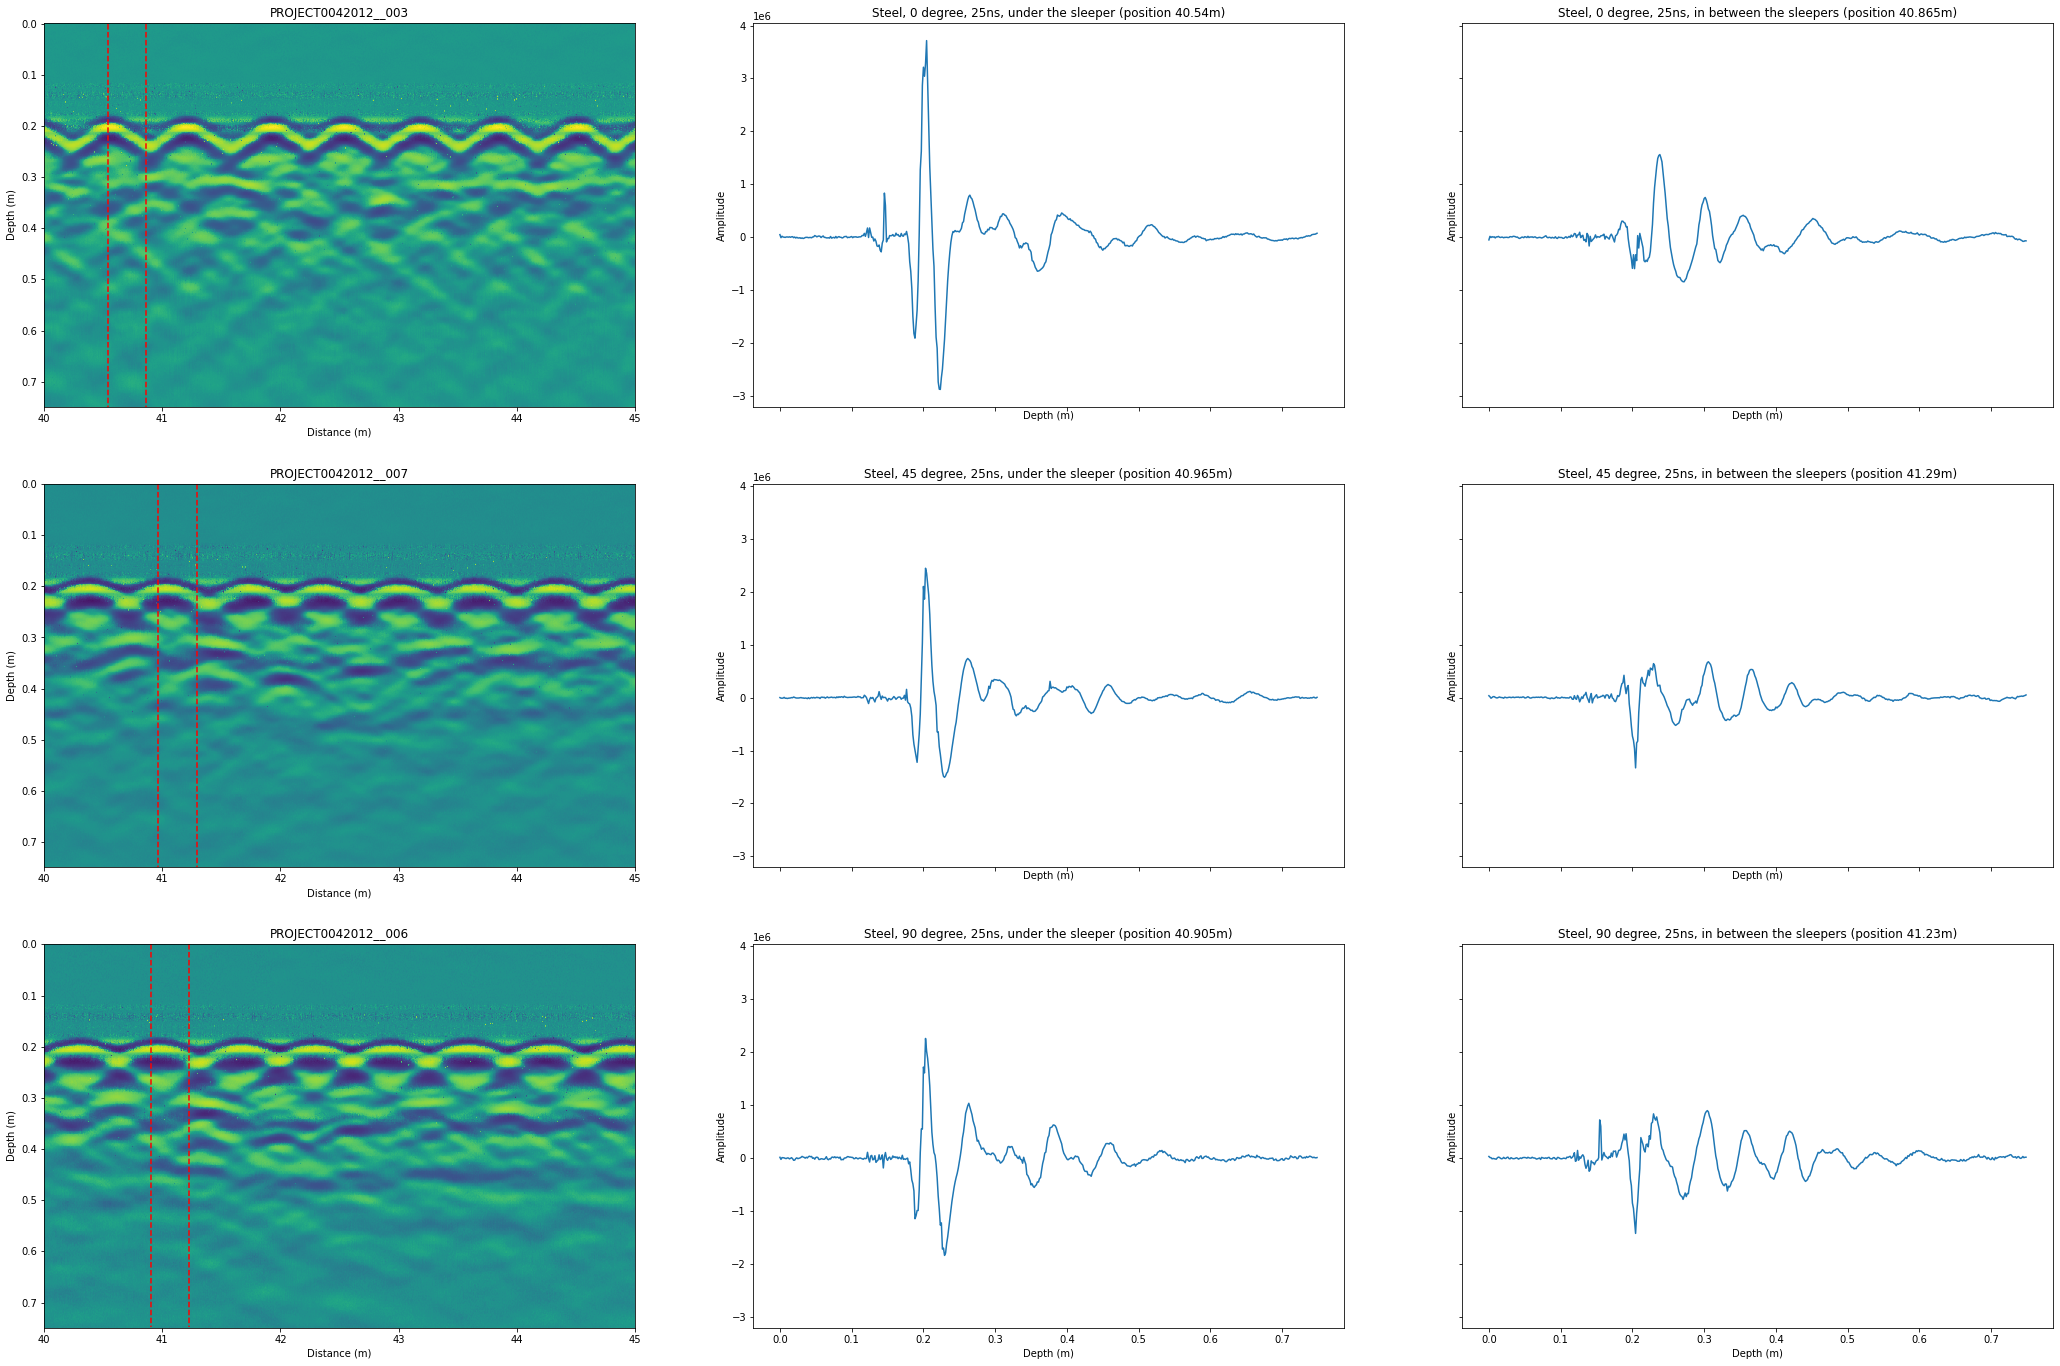

In [10]:
### Steel

_, ax = plt.subplots(3,3,figsize=(36,24))
set_share_axes(ax[:,0], sharex=True, sharey=True)
set_share_axes(ax[:,1:], sharex=True, sharey=True)

### 0 degree
x_sleeper_0, x_inbetween_0 = find_sleeper_and_space(array_0, x_0, position_low=40.5, position_high=41.5)
plot_radargram(ax[0][0], x_0, y_0, array_0, lim_inf=40, lim_sup=45, title=file_0, vlines=(x_sleeper_0, x_inbetween_0))
plot_amplitude_along_z(ax[0][1], x_0, y_0, array_0, x_sleeper_0, 
                           title=f'Steel, 0 degree, 25ns, under the sleeper (position {x_0[x_sleeper_0].round(3)}m)')
plot_amplitude_along_z(ax[0][2], x_0, y_0, array_0, x_inbetween_0, 
                           title=f'Steel, 0 degree, 25ns, in between the sleepers (position {x_0[x_inbetween_0].round(3)}m)')
### 45 degree
x_sleeper_45, x_inbetween_45 = find_sleeper_and_space(array_45, x_45, position_low=40.5, position_high=41.5)
plot_radargram(ax[1][0], x_45, y_45, array_45, lim_inf=40, lim_sup=45, title=file_45, vlines=(x_sleeper_45, x_inbetween_45))
plot_amplitude_along_z(ax[1][1], x_45, y_45, array_45, x_sleeper_45, 
                           title=f'Steel, 45 degree, 25ns, under the sleeper (position {x_45[x_sleeper_45].round(3)}m)')
plot_amplitude_along_z(ax[1][2], x_45, y_45, array_45, x_inbetween_45, 
                           title=f'Steel, 45 degree, 25ns, in between the sleepers (position {x_45[x_inbetween_45].round(3)}m)')
### 90 degree
x_sleeper_90, x_inbetween_90 = find_sleeper_and_space(array_90, x_90, position_low=40.5, position_high=41.5)
plot_radargram(ax[2][0], x_90, y_90, array_90, lim_inf=40, lim_sup=45, title=file_90, vlines=(x_sleeper_90, x_inbetween_90))
plot_amplitude_along_z(ax[2][1], x_90, y_90, array_90, x_sleeper_90, 
                           title=f'Steel, 90 degree, 25ns, under the sleeper (position {x_90[x_sleeper_90].round(3)}m)')
plot_amplitude_along_z(ax[2][2], x_90, y_90, array_90, x_inbetween_90, 
                           title=f'Steel, 90 degree, 25ns, in between the sleepers (position {x_90[x_inbetween_90].round(3)}m)')
#plt.savefig('comparison_9x9_steel')

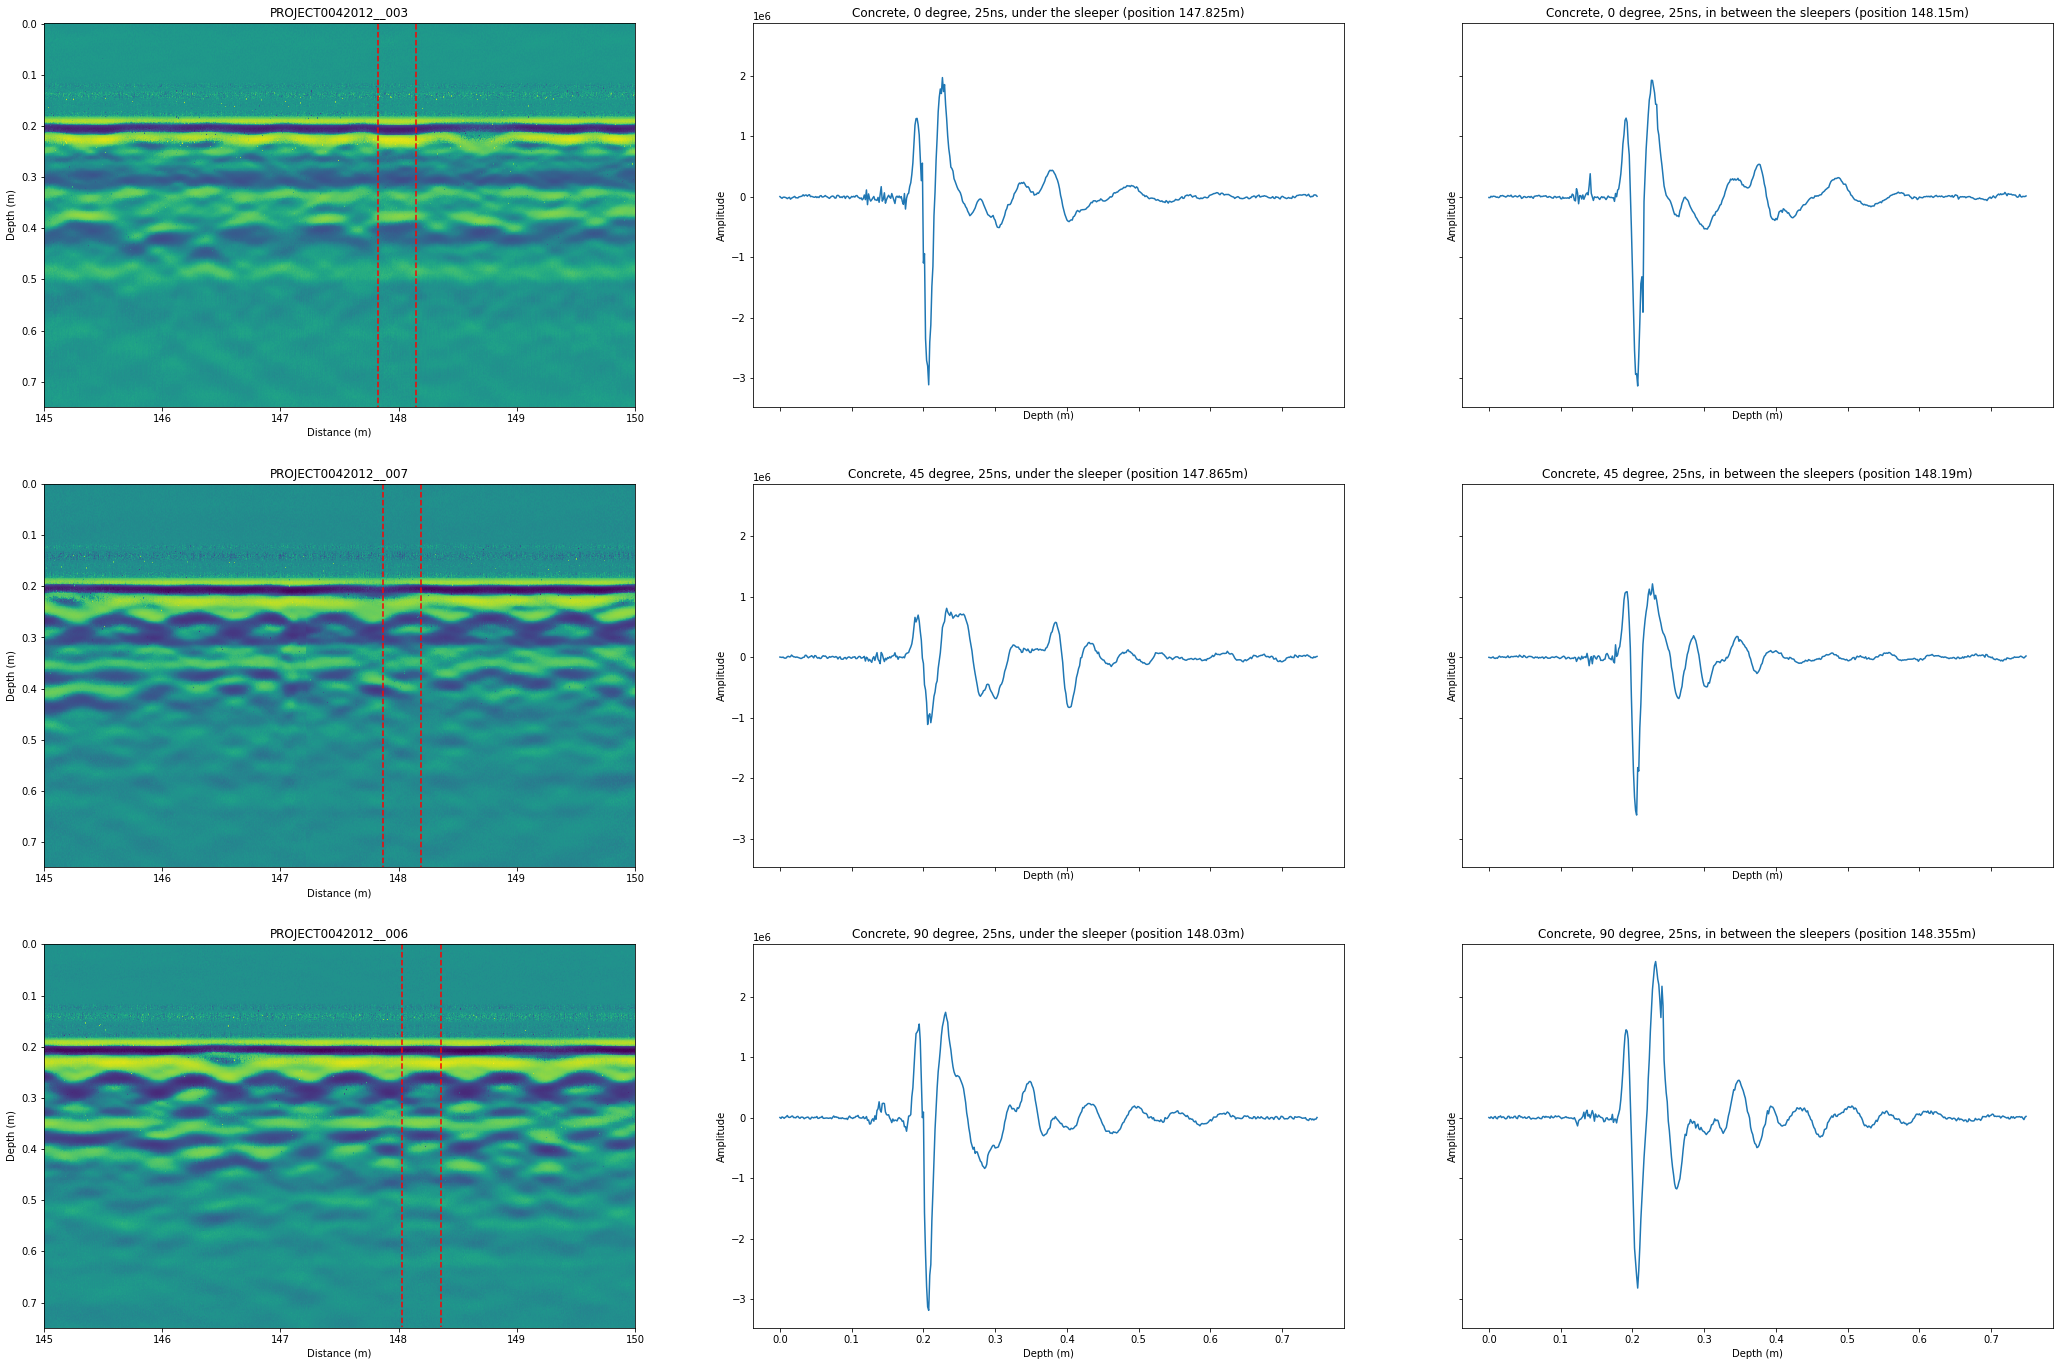

In [11]:
### Concrete

_, ax = plt.subplots(3,3,figsize=(36,24))
set_share_axes(ax[:,0], sharex=True, sharey=True)
set_share_axes(ax[:,1:], sharex=True, sharey=True)

### 0 degree
x_sleeper_0, x_inbetween_0 = find_sleeper_and_space(array_0, x_0, position_low=147.5, position_high=148.5)
plot_radargram(ax[0][0], x_0, y_0, array_0, lim_inf=145, lim_sup=150, title=file_0, vlines=(x_sleeper_0, x_inbetween_0))
plot_amplitude_along_z(ax[0][1], x_0, y_0, array_0, x_sleeper_0, 
                           title=f'Concrete, 0 degree, 25ns, under the sleeper (position {x_0[x_sleeper_0].round(3)}m)')
plot_amplitude_along_z(ax[0][2], x_0, y_0, array_0, x_inbetween_0, 
                           title=f'Concrete, 0 degree, 25ns, in between the sleepers (position {x_0[x_inbetween_0].round(3)}m)')
### 45 degree
x_sleeper_45, x_inbetween_45 = find_sleeper_and_space(array_45, x_45, position_low=147.5, position_high=148.5)
plot_radargram(ax[1][0], x_45, y_45, array_45, lim_inf=145, lim_sup=150, title=file_45, vlines=(x_sleeper_45, x_inbetween_45))
plot_amplitude_along_z(ax[1][1], x_45, y_45, array_45, x_sleeper_45, 
                           title=f'Concrete, 45 degree, 25ns, under the sleeper (position {x_45[x_sleeper_45].round(3)}m)')
plot_amplitude_along_z(ax[1][2], x_45, y_45, array_45, x_inbetween_45, 
                           title=f'Concrete, 45 degree, 25ns, in between the sleepers (position {x_45[x_inbetween_45].round(3)}m)')
### 90 degree
x_sleeper_90, x_inbetween_90 = find_sleeper_and_space(array_90, x_90, position_low=147.5, position_high=148.5)
plot_radargram(ax[2][0], x_90, y_90, array_90, lim_inf=145, lim_sup=150, title=file_90, vlines=(x_sleeper_90, x_inbetween_90))
plot_amplitude_along_z(ax[2][1], x_90, y_90, array_90, x_sleeper_90, 
                           title=f'Concrete, 90 degree, 25ns, under the sleeper (position {x_90[x_sleeper_90].round(3)}m)')
plot_amplitude_along_z(ax[2][2], x_90, y_90, array_90, x_inbetween_90, 
                           title=f'Concrete, 90 degree, 25ns, in between the sleepers (position {x_90[x_inbetween_90].round(3)}m)')
#plt.savefig('comparison_9x9_concrete')